In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.svm import SVR 
from functools import reduce

%matplotlib inline

In [2]:
data_filename = 'data/btsv01.txt'
rois = pd.read_csv(data_filename, delim_whitespace=True)
labels_train_filename = 'data/training_fluid_intelligenceV1.csv'
labels_val_filename = 'data/validation_fluid_intelligenceV1.csv'
labels_train = pd.read_csv(labels_train_filename, sep=',')
labels_val = pd.read_csv(labels_val_filename, sep=',')
print("Dataset shape: {}".format(rois.shape))
print("Labels train shape: {}".format(labels_train.shape))
print("Labels val shape: {}".format(labels_val.shape))

Dataset shape: (7803, 131)
Labels train shape: (3739, 2)
Labels val shape: (415, 2)


/Users/admin/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0,1,2,6,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
columns_description = rois.iloc[0]
#delete the row with description of the columns from data
rois_clean = rois.drop(rois.index[[0]])

In [4]:
print(columns_description)

collection_id                                                      collection_id
btsv01_id                                                              btsv01_id
dataset_id                                                            dataset_id
subjectkey                     The NDAR Global Unique Identifier (GUID) for r...
src_subject_id                        Subject ID how it's defined in lab/project
interview_date                 Date on which the interview/genetic test/sampl...
interview_age                  Age in months at the time of the interview/tes...
gender                                                        Sex of the subject
sri24precentrallgm                      left precentral gyrus gray matter volume
sri24precentralrgm                     right precentral gyrus gray matter volume
sri24frontalsuplgm             left superior frontal gyrus, dorsolater gray m...
sri24frontalsuprgm             right superior frontal gyrus, dorsolater gray ...
sri24frontalsuporblgm       

In [5]:
print("Number of rows: {}".format(rois_clean.shape[0]))
print("Number of columns: {}".format(rois_clean.shape[1]))

Number of rows: 7802
Number of columns: 131


In [6]:
len(set(labels_train['subject']).intersection(set(rois_clean['subjectkey'])))

3739

Now, we found that our labels with residual fluid intelligence scores are a subset of values in a column 'subjectkey'.
We are constructing a training set, therefore in the training set we will only consider those entries that also have labels. <br>
Furthermore, we are eliminating the following columns: 
- btsv01_id
- interview_date
- collection_id
- dataset_id
- collection_title
- src_subject_id (which is the repetition of subjectkey, but with lowercase letters (for some mysterious reason))

In [7]:
rois_clean = rois_clean.drop(['btsv01_id', 'interview_date', 'collection_id', \
                              'dataset_id', 'collection_title', 'src_subject_id'], axis=1)

In [8]:
#now we are changing the string values of gender to number
gender_to_int = {
    'M': 0,
    'F': 1
}

rois_clean['gender'] = rois_clean['gender'].apply(lambda x: gender_to_int[x])
# rois_clean = pd.get_dummies(rois_clean, columns=['gender'])
#skip gender in this analysis
rois_clean = rois_clean.drop(['gender'], axis=1)

## Create training and validation dataset 

In [9]:
train_data = rois_clean[rois_clean['subjectkey'].isin(labels_train['subject'])]
val_data = rois_clean[rois_clean['subjectkey'].isin(labels_val['subject'])]

In [10]:
train_data_labels = pd.merge(train_data, labels_train, left_on='subjectkey', right_on='subject').drop(['subject'], axis=1)
val_data_labels = pd.merge(val_data, labels_val, left_on='subjectkey', right_on='subject').drop(['subject'], axis=1)

In [51]:
#load features from the images
means_train = pd.read_csv('data/training_data_means.csv', header=None, prefix='m', index_col=0).fillna(0)
means_val = pd.read_csv('data/validation_data_means.csv', header=None, prefix='m', index_col=0).fillna(0)
std_train = pd.read_csv('data/training_data_stdevs.csv', header=None, prefix='std', index_col=0).fillna(0)
std_val = pd.read_csv('data/validation_data_stdevs.csv', header=None, prefix='std', index_col=0).fillna(0)
entropy_train = pd.read_csv('data/training_data_entropy.csv', header=None, prefix='e', index_col=0).fillna(0)
entropy_val = pd.read_csv('data/validation_data_entropy.csv', header=None, prefix='e', index_col=0).fillna(0)

extra_dfs = [means_train, means_val, std_train, std_val, entropy_train, entropy_val]
for df in extra_dfs:
    df.index.name = 'subjectkey'


In [52]:
train_additional_features = reduce(lambda left,right: pd.merge(left,right,on='subjectkey'), [means_train, std_train, entropy_train])
val_additional_features =  reduce(lambda left,right: pd.merge(left,right,on='subjectkey'), [means_val, std_val, entropy_val])

In [57]:
#here we will construct a matrix only with data - without labels
#the first column is identification - it is a string and we want to delete it. Other columns are identified as string,
#but we want to convert it to floats and to the matrix

def generate_dataset(df_train, df_val, include_additional=True):
    #the input is the dataframe with both data and labels in the last column
    train_labels = df_train['residual_fluid_intelligence_score'].astype(np.float).values
    val_labels = df_val['residual_fluid_intelligence_score'].astype(np.float).values
    if include_additional: 
        train_data = pd.merge(df_train, train_additional_features, on='subjectkey').drop(['subjectkey'], axis=1).values[:,:-1].astype(np.float)
        val_data = pd.merge(df_val, val_additional_features, on='subjectkey').drop(['subjectkey'], axis=1).values[:,:-1].astype(np.float)
    else:
        train_data = df_train.drop(['subjectkey'], axis=1).values[:,:-1].astype(np.float)
        val_data = df_val.drop(['subjectkey'], axis=1).values[:,:-1].astype(np.float)
    return train_data, train_labels, val_data, val_labels

train_data, train_labels, val_data, val_labels = generate_dataset(train_data_labels, val_data_labels, include_additional=False)
train_data_extra, train_labels_extra, val_data_extra, val_labels_extra = generate_dataset(train_data_labels, val_data_labels, include_additional=True)

In [58]:
#now for the final form - train_data/val_data will be our matrices; train_labels, val_labels will be our residuals
dataset_columns = train_data_labels.columns 
#important: the last two columns are now binarized wrt to genders

In [59]:
print(dataset_columns)

Index(['subjectkey', 'interview_age', 'sri24precentrallgm',
       'sri24precentralrgm', 'sri24frontalsuplgm', 'sri24frontalsuprgm',
       'sri24frontalsuporblgm', 'sri24frontalsuporbrgm', 'sri24frontalmidlgm',
       'sri24frontalmidrgm',
       ...
       'sri24ponswm', 'sri24corpuscallosumwm', 'sri24wm400wm400lwm',
       'sri24wm400wm400rwm', 'sri24vtlslateralvtllcsf',
       'sri24vtlslateralvtlrcsf', 'sri24vtlsthirdvtllcsf',
       'sri24vtlsthirdvtlrcsf', 'sri24suptentsupratentoriumv',
       'residual_fluid_intelligence_score'],
      dtype='object', length=125)


# Experiment on the initial features

### Distribution of residual values (what are our labels?)

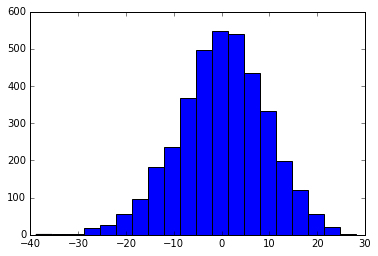

In [16]:
plt.hist(train_labels, bins=20)
plt.show()

### How many Nans we have?

In [17]:
np.unique(train_data[:,90])

array([ 7293.39,  7716.8 ,  8031.32, ..., 15400.2 , 15799.6 , 16779.8 ])

### PCA

In [18]:
#first normalize with respect to column
def normalize_data(data: np.array, standardize=True):
    means = np.mean(data, axis=0)
    stds = np.std(data, axis=0)
    if not standardize:
        return data-means
    return (data-means)/stds


In [19]:
train_norm_data = normalize_data(train_data)
val_norm_data = normalize_data(val_data)

In [20]:
n_components = [2,3,4,5,6,7,8,9,10]
for n in n_components:
    curr_pca = PCA(n_components=n)
    curr_pca.fit_transform(train_norm_data)
    print("For {} components, the explained variance by them is : {:.3f}".format(n, np.sum(curr_pca.explained_variance_ratio_)))

print("*"*10)
explained_variance = [0.8, 0.85, 0.9, 0.95]
for target_variance in explained_variance:
    curr_pca = PCA(n_components=target_variance)
    curr_pca.fit_transform(train_norm_data)
    print("The {} variance ratio is explained by {} components ".format(target_variance, np.sum(curr_pca.n_components_)))


For 2 components, the explained variance by them is : 0.152
For 3 components, the explained variance by them is : 0.191
For 4 components, the explained variance by them is : 0.225
For 5 components, the explained variance by them is : 0.254
For 6 components, the explained variance by them is : 0.281
For 7 components, the explained variance by them is : 0.305
For 8 components, the explained variance by them is : 0.327
For 9 components, the explained variance by them is : 0.347
For 10 components, the explained variance by them is : 0.365
**********
The 0.8 variance ratio is explained by 57 components 
The 0.85 variance ratio is explained by 66 components 
The 0.9 variance ratio is explained by 78 components 
The 0.95 variance ratio is explained by 92 components 


### Covariance matrix of features

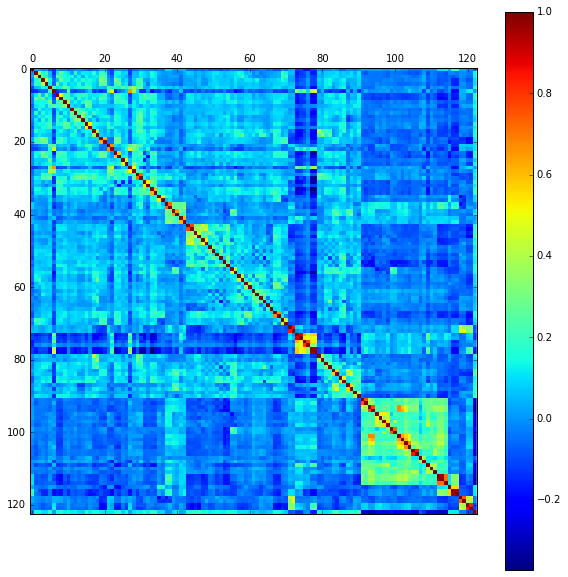

In [21]:
def compute_covariance(matrix):
    return matrix.T.dot(matrix)/matrix.shape[0]

cov_matrix = compute_covariance(train_norm_data)
fig, ax = plt.subplots(figsize=(10,10))
im = ax.matshow(cov_matrix, interpolation='none')
fig.colorbar(im, ticks=[-1,-0.8,-0.6,-0.4,-0.2,0.0,0.2,0.4,0.6,0.8,1.0])
plt.show()

In [22]:
def get_eigenvalues(data, n_comps, standardize=True):
    normalized_data = normalize_data(data, standardize)
    cov_matrix = compute_covariance(normalized_data)
    pca = PCA(n_comps)
    pca.fit_transform(normalized_data)
    eigenvectors = pca.components_
    eigenvalues = []
    for ev in eigenvectors:
        eigenvalues.append(np.dot(ev.T, np.dot(cov_matrix, ev)))
    print(pca.explained_variance_)
    return eigenvalues

In [23]:
get_eigenvalues(train_data, 3)

[11.33334393  7.37416556  4.77442186]


[11.330312816056354, 7.372193328169707, 4.773146849617659]

### Evaluating feature importance
http://jotterbach.github.io/2016/03/24/Principal_Component_Analysis/

/Users/admin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in log


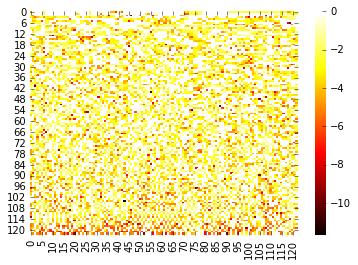

In [24]:
inv_pca = PCA()
pca_data = inv_pca.fit_transform(train_norm_data)

feature_importance = np.nan_to_num(np.log(inv_pca.inverse_transform(np.eye(train_norm_data.shape[1]))))

sns.heatmap(feature_importance, cmap="hot", cbar=True)

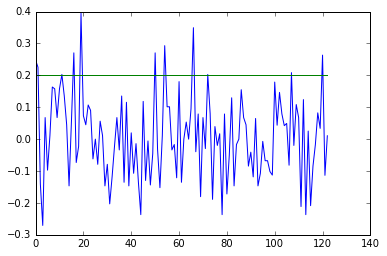

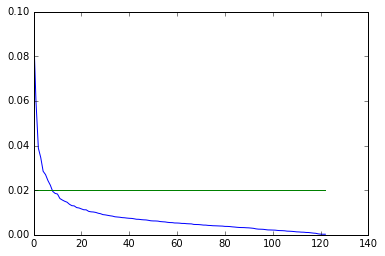

In [25]:
means = np.mean(pca_data, axis=0)/np.sum(np.mean(pca_data, axis=0))
variances = np.var(pca_data, axis=0)/np.sum(np.var(pca_data, axis=0))
xs = [x for x in range(train_norm_data.shape[1])]
mean_threshold = [0.2 for x in xs]
variance_threshold = [0.02 for x in xs]
plt.plot(xs, means)
plt.plot(xs, mean_threshold)
plt.show()

plt.plot(xs, variances)
plt.plot(xs, variance_threshold)
plt.show()

## SVM with all features and with carefully selected features

In [26]:
from sklearn.utils.class_weight import compute_sample_weight

def mse(real, pred):
    return np.mean(np.square(real-pred))


weights = compute_sample_weight('balanced', train_labels)


In [27]:
svr = SVR()
svr.fit(train_norm_data, train_labels, sample_weight=weights)

preds = svr.predict(normalize_data(val_data))
print(mse(preds, val_labels)) #all original features 
print(svr.score(normalize_data(val_data), val_labels))

73.37395659208056
-0.025847163151464292


In [28]:
#random baseline
random_labels = np.random.normal(np.mean(train_labels), np.std(train_labels), len(val_labels))
mse(random_labels, val_labels)

147.8210903212774

In [29]:
#majority baseline
majority_labels = [np.mean(train_labels) for x in range(len(val_labels))]
mse(majority_labels, val_labels)

71.83710478844851

#### Choosing features above the thresholds

In [30]:
#choose features above the thresholds
mean_based_features = np.where(means >= mean_threshold)[0]
variance_based_features = np.where(variances >= variance_threshold)[0]
# chosen_features = np.array(list(set(mean_based_features).union(set(variance_based_features))))
chosen_features = np.array([x for x in range(70, 120)])
print(len(chosen_features))

50


In [31]:
svr.fit(train_norm_data[:, chosen_features], train_labels)
preds_chosen = svr.predict(normalize_data(val_data)[:, chosen_features])
print(mse(preds_chosen, val_labels))
print(svr.score(normalize_data(val_data)[:, chosen_features], val_labels))

72.68810780716284
-0.01625825636441136


In [32]:
# !pip install xgboost

In [33]:
from sklearn.ensemble import RandomForestRegressor
forest_regressor = RandomForestRegressor(100)
forest_regressor.fit(train_norm_data, train_labels, sample_weight=weights)
forest_preds = forest_regressor.predict(normalize_data(val_data))
print(mse(forest_preds, val_labels))
print(forest_regressor.score(normalize_data(val_data), val_labels))

71.4404244500454
0.0011857045702015068


### Generating the frontal ratios and using them as additional features

In [34]:
is_frontal = np.array([x-1 for x in range(len(dataset_columns)) if 'frontal' in dataset_columns[x]])
is_suptent = np.array([x-1 for x in range(len(dataset_columns)) if 'supratentorium' in dataset_columns[x]])
#1 detect frontal
#2 dodać objętości frontala -> wspolczynnik frontal w calym mozgu

In [35]:
structures_to_delete = ['thalamus', 'caudate', 'putamen', 'pallidum', 'volume', 'wm', 'supratentorium', 'csf']

cortex_indices = []

for i,column in enumerate(dataset_columns):
    curr_deletes = []
    for name in structures_to_delete: 
        if name in column:
            curr_deletes.append(name)
    if len(curr_deletes)==0 and i-1>=0:
        cortex_indices.append(i-1)

cortex_indices = np.array(cortex_indices)
cortex_indices = cortex_indices[cortex_indices < 123]

def generate_frontal_ratio(frontal_inds, reference_inds, data):
    coefs = []
    for observation in data:
        frontal_volume = np.sum(observation[frontal_inds])
        reference_volume = np.sum(observation[reference_inds])
        coefs.append(frontal_volume/reference_volume)
    return coefs

frontal_coef = normalize_data(generate_frontal_ratio(is_frontal, is_suptent, train_data)).reshape(-1,1)
frontal_coef2 = normalize_data(generate_frontal_ratio(is_frontal, cortex_indices, train_data)).reshape(-1,1)
frontal_coef_val = generate_frontal_ratio(is_frontal, is_suptent, val_data)
frontal_coef2_val = generate_frontal_ratio(is_frontal, cortex_indices, val_data)

In [36]:
frontal_coef_val = normalize_data(frontal_coef_val).reshape(-1,1)
frontal_coef2_val = normalize_data(frontal_coef2_val).reshape(-1,1)


In [37]:
train_norm_data_extra = np.append(train_norm_data, np.hstack((frontal_coef, frontal_coef2)), axis=1)[:,110:]
val_norm_data_extra = np.append(val_norm_data, np.hstack((frontal_coef_val, frontal_coef2_val)), axis=1)[:,110:]
svr.fit(train_norm_data_extra, train_labels, sample_weight=weights)
preds_with_adds = svr.predict(val_norm_data_extra) #only ratios
print(mse(preds_with_adds, val_labels))


71.6711670318626


# Experiments with augmented feature space

In [60]:
train_norm_data_e = np.nan_to_num(normalize_data(train_data_extra))
val_norm_data_e = np.nan_to_num(normalize_data(val_data_extra))

svr.fit(train_norm_data_e, train_labels_extra)
preds_extra = svr.predict(val_norm_data_e)
print(mse(preds_extra, val_labels_extra))

/Users/admin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide


36.39201329722988


(-30, 30)

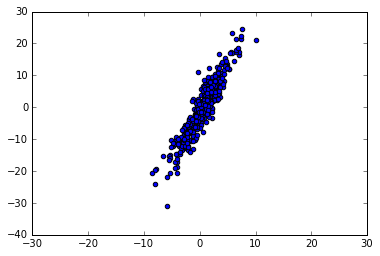

In [63]:
plt.scatter(preds_extra, val_labels)
plt.xlim(-30,30)

In [75]:
train_norm_data_extra = np.append(train_norm_data_e, np.hstack((frontal_coef, frontal_coef2)), axis=1)[:,92:]
val_norm_data_extra = np.append(val_norm_data_e, np.hstack((frontal_coef_val, frontal_coef2_val)), axis=1)[:,92:]
svr.fit(train_norm_data_extra, train_labels, sample_weight=weights)
preds_with_adds = svr.predict(val_norm_data_extra) #only ratios
print(mse(preds_with_adds, val_labels))


26.716778545758967


In [69]:
val_norm_data_extra.shape

(415, 530)

In [93]:
prefrontal_list = pd.read_csv('data/prefrontal_list.csv', header=None)
prefrontal_ids = [list(dataset_columns).index(x)-1 for x in list(prefrontal_list.values[0])]
for x in range(123,train_norm_data_extra.shape[1]):
    prefrontal_ids.append(x)
    
prefrontal_ids = np.array(prefrontal_ids)

In [94]:
train_norm_data_extra = np.append(train_norm_data_e, np.hstack((frontal_coef, frontal_coef2)), axis=1)[:,prefrontal_ids]
val_norm_data_extra = np.append(val_norm_data_e, np.hstack((frontal_coef_val, frontal_coef2_val)), axis=1)[:,prefrontal_ids]
svr.fit(train_norm_data_extra, train_labels, sample_weight=weights)
preds_with_adds = svr.predict(val_norm_data_extra) #only ratios
print(mse(preds_with_adds, val_labels))


73.03333428754988


In [95]:
prefrontal_ids

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 25, 26, 31,
       32, 33, 34])

3739